# Explore Model Embeddings

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/jovyan/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from typing import List, Union, Optional, Tuple, Dict

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
# data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')
# plot_dir = Path('/Users/tommylees/Downloads')

assert data_dir.exists()

In [3]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data

In [4]:
# EXPERIMENT =      'ICLR_one_month_forecast_BOKU_boku_VCI_our_vars_ALL'
EXPERIMENT =      'one_month_forecast'
# TRUE_EXPERIMENT = 'ICLR_one_month_forecast_BOKU_boku_VCI_our_vars_ALL'
TRUE_EXPERIMENT = 'one_month_forecast'
TARGET_VAR =      'boku_VCI'

assert (data_dir / f'models/{EXPERIMENT}').exists()
assert (data_dir / f'models/{TRUE_EXPERIMENT}').exists()

print((data_dir / f'models/{EXPERIMENT}').as_posix())

data/models/one_month_forecast


# Read in the data

In [5]:
X_train, y_train = read_train_data(data_dir, experiment=TRUE_EXPERIMENT)
X_test, y_test = read_test_data(data_dir, experiment=TRUE_EXPERIMENT)
static_ds = xr.open_dataset(data_dir / "features/static/data.nc")

ds = xr.merge([y_train, y_test]).sortby('time').sortby('lat')
d_ = xr.merge([X_train, X_test]).sortby('time').sortby('lat')
ds = xr.merge([ds, d_])

In [6]:
print("TRAINING DATA")
display(ds)
print('\n\n')
print("TARGET DATA")
display(y_test)

TRAINING DATA


<xarray.Dataset>
Dimensions:     (lat: 45, lon: 35, time: 205)
Coordinates:
  * time        (time) datetime64[ns] 2001-12-31 2002-01-31 ... 2018-12-31
  * lat         (lat) float32 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.25 5.5 5.75 6.0
  * lon         (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
Data variables:
    boku_VCI    (time, lat, lon) float64 100.0 100.0 98.82 ... 11.94 78.34 40.51
    VCI3M       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    modis_ndvi  (time, lat, lon) float64 0.688 0.5456 0.7328 ... nan nan nan
    VCI         (time, lat, lon) float64 57.69 89.55 63.82 45.12 ... nan nan nan
    precip      (time, lat, lon) float64 102.0 107.6 122.3 111.1 ... nan nan nan
    E           (time, lat, lon) float64 85.9 60.61 60.61 57.43 ... nan nan nan
    Eb          (time, lat, lon) float64 3.518 1.266 1.266 2.995 ... nan nan nan
    SMroot      (time, lat, lon) float64 0.2638 0.2245 0.2245 ... nan nan nan
    SMsurf      (time, lat, lon) float64 0.2978 0.2648 0.2648 ... nan nan nan
    p84.162     (time, lat, lon) float64 1.45e-05 -5.456e-05 ... nan nan
    pev         (time, lat, lon) float64 -0.005993 -0.006077 ... nan nan
    sp          (time, lat, lon) float64 8.862e+04 8.927e+04 ... nan nan
    t2m         (time, lat, lon) float64 297.5 298.4 297.4 296.2 ... nan nan nan
    tp          (time, lat, lon) float64 0.003657 0.00285 0.004386 ... nan nan




TARGET DATA


<xarray.Dataset>
Dimensions:   (lat: 45, lon: 35, time: 36)
Coordinates:
  * lat       (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.0 -4.25 -4.5 -4.75 -5.0
  * lon       (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * time      (time) datetime64[ns] 2016-01-31 2016-02-29 ... 2018-12-31
Data variables:
    boku_VCI  (time, lat, lon) float64 64.45 52.16 97.37 96.48 ... nan nan nan

In [7]:
from src.utils import get_ds_mask
mask = get_ds_mask(X_train.VCI)

# bline_pred = read_pred_data('previous_month', data_dir, experiment=EXPERIMENT)[-1].where(~mask)
# lstm_pred = read_pred_data('rnn', data_dir, experiment=EXPERIMENT)[-1].where(~mask)
ealstm_pred = read_pred_data('ealstm', data_dir, experiment=EXPERIMENT)[-1].where(~mask)

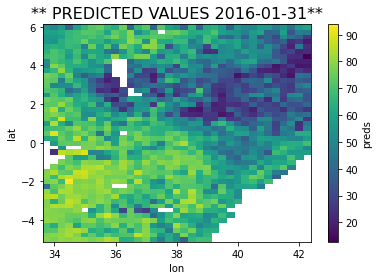

In [8]:
fig, ax = plt.subplots()
time_ix = 0
time = ealstm_pred.isel(time=time_ix).time.values
ealstm_pred.isel(time=time_ix).plot(ax=ax)
ax.set_title(f"** PREDICTED VALUES {str(time).split('T')[0]}**", size=16);

# Read in the models
Input data:
* boku_VCI    
* pev         
* t2m         
* precip      
* E           
* SMroot      
* SMsurf


\+ each variables SPATIAL MEAN (therefore 14 input variables)

In [9]:
from src.models import load_model

In [10]:
ealstm = load_model(data_dir / 'models' / EXPERIMENT / 'ealstm' / 'model.pt')
# lstm = load_model(data_dir / 'models' / EXPERIMENT / 'rnn' / 'model.pt')

In [11]:
ealstm.models_dir = data_dir / 'models' / EXPERIMENT
# lstm.models_dir = data_dir / 'models' / EXPERIMENT

ealstm.experiment = TRUE_EXPERIMENT
ealstm.features_per_month  # x.shape[-1] = the number of features in dynamic data 

16

In [12]:
ealstm.ignore_vars

['p84.162', 'sp', 'tp', 'Eb', 'VCI', 'modis_ndvi']

# checks of the static data

In [13]:
dl = ealstm.get_dataloader('train', batch_file_size=1, shuffle_data=False)
train_iter = iter(dl)
static_data = train_iter.static
static_data

<xarray.Dataset>
Dimensions:                                     (lat: 45, lon: 35)
Coordinates:
  * lon                                         (lon) float32 33.75 ... 42.25
  * lat                                         (lat) float32 6.0 5.75 ... -5.0
Data variables:
    precip_global_mean                          (lat, lon) float64 ...
    E_global_mean                               (lat, lon) float64 ...
    SMroot_global_mean                          (lat, lon) float64 ...
    SMsurf_global_mean                          (lat, lon) float64 ...
    pev_global_mean                             (lat, lon) float64 ...
    t2m_global_mean                             (lat, lon) float64 ...
    precip_pixel_mean                           (lat, lon) float64 ...
    E_pixel_mean                                (lat, lon) float64 ...
    SMroot_pixel_mean                           (lat, lon) float64 ...
    SMsurf_pixel_mean                           (lat, lon) float64 ...
    pev_pixel_mean                              (lat, lon) float64 ...
    t2m_pixel_mean                              (lat, lon) float64 ...
    topography                                  (lat, lon) float32 ...
    lc_class                                    (lat, lon) float64 ...
    lc_class_group                              (lat, lon) int64 ...
    no_data_one_hot                             (lat, lon) float64 ...
    cropland_rainfed_one_hot                    (lat, lon) float64 ...
    herbaceous_cover_one_hot                    (lat, lon) float64 ...
    tree_or_shrub_cover_one_hot                 (lat, lon) float64 ...
    cropland_irrigated_or_postflooding_one_hot  (lat, lon) float64 ...
    tree_cover_one_hot                          (lat, lon) float64 ...
    shrubland_one_hot                           (lat, lon) float64 ...
    grassland_one_hot                           (lat, lon) float64 ...
    lichens_and_mosses_one_hot                  (lat, lon) float64 ...
    urban_areas_one_hot                         (lat, lon) float64 ...
    bare_areas_one_hot                          (lat, lon) float64 ...
    water_bodies_one_hot                        (lat, lon) float64 ...
    permanent_snow_and_ice_one_hot              (lat, lon) float64 ...
    slt                                         (lat, lon) float64 ...

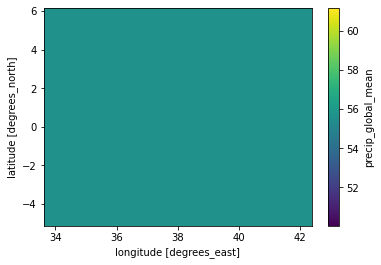

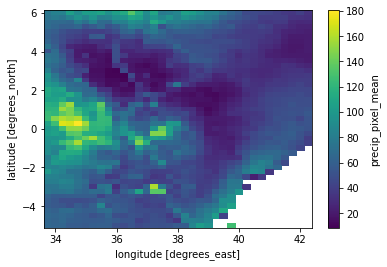

In [14]:
global_vars = [v for v in static_data if 'global' in v]
pixel_vars = [v for v in static_data if 'pixel' in v]

fig, ax = plt.subplots()
static_data[global_vars[0]].plot(ax=ax)
fig, ax = plt.subplots()
static_data[pixel_vars[0]].plot(ax=ax)

# Interpret Model Static layer

In [15]:
dir(ealstm)

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_concatenate_data',
 '_convert_delta_to_raw_values',
 '_get_background',
 '_get_morris_explanations',
 '_get_shap_explanations',
 '_initialize_model',
 '_input_to_tuple',
 '_load_spatial_mask',
 '_make_analysis_folder',
 '_one_hot',
 'batch_size',
 'clear_nans',
 'current_size',
 'data_path',
 'data_vars',
 'denormalize_y',
 'dense_features',
 'device',
 'evaluate',
 'experiment',
 'explain',
 'explainer',
 'features_per_month',
 'get_dataloader',
 'hidden_size',
 'ignore_vars',
 'include_latlons',
 'include_monthly_aggs',
 'include_pred_month',
 'include_prev_y',
 'include_yearly_aggs',
 'input_dense',
 'load',
 'model',
 'model_dir',
 'model_name',
 'models_dir',
 'normalize_y',
 'normalizing_dict',
 'num_locations',
 'pred_months',
 'predict',
 'predict_delta',
 'rnn_dropout',
 'save_model',
 'spatial_mask',
 'static',
 'static_embedding_size',
 'static_size',
 'surrounding_pixels',
 'to',
 'train',
 'yearly_agg_size']

In [16]:
# ealstm.yearly_agg_size
ealstm.model.static_embedding

Linear(in_features=43, out_features=64, bias=True)

In [17]:
from typing import Tuple


def sigmoid(x):
    return 1/(1 + np.exp(-x))


def build_static_x(x: Tuple[np.array], ) -> Tuple[List[np.array], List[np.array], List[np.array]]:
    all_static_x = []
    all_latlons = []
    all_pred_months = []

    for i in range(len(x)):  # EACH BATCH (of X,y pairs)
        pred_month_data = x[i][1]
        latlons_data = x[i][2]
        yearly_aggs_data = x[i][4]
        static_data = x[i][5]
        assert static_data.shape[-1] == 29, f"{static_data.shape}"
        # print()
        # print("pred_month_data.shape", (pred_month_data.shape[0], 12) if pred_month_data is not None else "None")
        # print("latlons_data.shape", latlons_data.shape if latlons_data is not None else "None")
        # print("yearly_aggs_data.shape", yearly_aggs_data.shape if yearly_aggs_data is not None else "None")
        # print("static_data.shape", static_data.shape if static_data is not None else "None")
        # break
        
        # append the static_arrays
        static_x = []
        # normalise latlon
        static_x.append((latlons_data - latlons_data.mean(axis=0)) / latlons_data.std(axis=0))  # 0, 1
        static_x.append(yearly_aggs_data)  # 2: 9
        static_x.append(static_data)
        # one_hot_encode the pred_month_data
        try:
            static_x.append(ealstm._one_hot(torch.from_numpy(pred_month_data), 12).numpy())
        except TypeError:
            static_x.append(ealstm._one_hot(torch.from_numpy(pred_month_data), 12).cpu().numpy())
        
        # exclude Nones
        static_x = np.concatenate([x for x in static_x if x is not None], axis=-1)
        # print("Static X Data Shape: ", static_x.shape)
        
        # all data
        all_static_x.append(static_x)

        # metadata (latlons and pred_months)
        all_latlons.append(latlons_data)
        all_pred_months.append(pred_month_data)
        
    return all_static_x, all_latlons, all_pred_months


def calculate_embeddings(static_x: np.ndarray, W: np.ndarray, b: np.array) -> np.array:
    assert W.T.shape[0] == static_x.shape[-1], f"Matrix operations must be valid {static_x.shape} * {W.T.shape}"
    
    embedding = []
    for pixel_ix in range(static_x.shape[0]):
        embedding.append(sigmoid(np.dot(W, static_x[pixel_ix]) + b))
    return np.array(embedding)


def get_train_mask(ealstm):
    val_split = 0.1
    len_mask = len(
        DataLoader._load_datasets(
            ealstm.data_path,
            mode="train",
            experiment=EXPERIMENT,
            shuffle_data=False,
            pred_months=None,
        )
    )
    train_mask, val_mask = train_val_mask(len_mask, val_split)
    return train_mask


def get_static_embedding(ealstm) -> Tuple[List[np.array], Tuple[List[np.array], np.array, List[np.array]]]:
    # get W, b from state_dict
    od = ealstm.model.static_embedding.state_dict()
    try:
        W = od['weight'].numpy()
        b = od['bias'].numpy()
    except TypeError:
        W = od['weight'].cpu().numpy()
        b = od['bias'].cpu().numpy()
        
    # get X_static data from dataloader
    print("Calling Training DataLoader")
    dl = ealstm.get_dataloader('train', batch_file_size=1, shuffle_data=False)
    x = [x for (x, y) in dl]
        
    # build static_x matrix
    all_static_x, all_latlons, all_pred_months = build_static_x(x)
    # check w^Tx + b is a valid matrix operation
    assert W.T.shape[0] == all_static_x[0].shape[-1], f"W.T shape: {W.T.shape} static_x shape: {all_static_x[0].shape}"
    
    # calculate the embeddings
    all_embeddings = []
    for static_x in all_static_x:
        embedding = calculate_embeddings(static_x, W=W, b=b)
        all_embeddings.append(embedding)
        
    return all_embeddings, (all_static_x, np.array(all_latlons), np.array(all_pred_months))

all_e, (all_static_x, all_latlons, all_pred_months) = get_static_embedding(ealstm=ealstm)

Calling Training DataLoader
data/features/one_month_forecast/train/2002_3 returns no values. Skipping
data/features/one_month_forecast/train/2002_4 returns no values. Skipping


#### TODO: why do these exist?
- Remove the static months where there are more than one pred_months
- there should only be one pred_month per static embedding

In [18]:
pred_months_err_mask = [len(np.unique(pm)) == 1 for pm in all_pred_months]
all_e = np.array(all_e)[pred_months_err_mask]
all_static_x = np.array(all_static_x)[pred_months_err_mask]
all_pred_months = np.array(all_pred_months)[pred_months_err_mask]
all_latlons = np.array(all_latlons)[pred_months_err_mask]

assert all_latlons.shape == all_static_x.shape
assert all_pred_months.shape == all_e.shape

# assert all timsteps have only 1 pred month
assert all([i == 1 for i in [len(np.unique(pm)) for pm in all_pred_months]])

### Sort by the pred month

In [19]:
def sort_by_another_list(list_to_sort, list_to_sort_on):
    assert len(list_to_sort) == len(list_to_sort_on)
    sort_ixs = np.argsort(list_to_sort_on)
    return list_to_sort[sort_ixs]


# SORTBY month
pred_months = [int(np.unique(pm)) for pm in all_pred_months]

all_e = sort_by_another_list(all_e, pred_months)
all_static_x = sort_by_another_list(all_static_x, pred_months)
all_latlons = sort_by_another_list(all_latlons, pred_months)
all_pred_months = sort_by_another_list(all_pred_months, pred_months)

In [20]:
print(len(all_e))
[emb.shape for emb in all_e]
print(len(all_latlons))

160
160


# Are they actually Static?

In [21]:
pred_months = [int(np.unique(pm)) for pm in all_pred_months]
pred_months

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12]

In [22]:
import calendar
# get the unique indexes of the months (from pred_months)
unique_ids = [pred_months.index(x) for x in set(pred_months)]

# check the first for that month against the others for that month
for id_1, id_2, month in zip(unique_ids, [id_ + 1 for id_ in unique_ids], set(pred_months)):
    mth = calendar.month_abbr[month]
    if all_e[id_1].shape == all_e[id_2].shape:
        print(f"1 {mth}: ", np.all(all_e[id_1] == all_e[id_2]))
    elif all_e[id_1 + 1].shape == all_e[id_2 + 1].shape:
        print(f"2 {mth}: ", np.all(all_e[id_1 + 1] == all_e[id_2 + 1]))
    elif all_e[id_1 + 1].shape == all_e[id_2 + 2].shape:
        print(f"3 {mth}: ", np.all(all_e[id_1 + 1] == all_e[id_2 + 2]))
    elif all_e[id_1 + 1].shape == all_e[id_2 + 3].shape:
        print(f"4 {mth}: ", np.all(all_e[id_1 + 1] == all_e[id_2 + 3]))
    elif all_e[id_1 + 1].shape == all_e[id_2 + 4].shape:
        print(f"5 {mth}: ", np.all(all_e[id_1 + 1] == all_e[id_2 + 4]))
    else:
        print(f"# {mth}: UNABLE TO FIND matching shape")

# Jan: UNABLE TO FIND matching shape
2 Feb:  False
# Mar: UNABLE TO FIND matching shape
2 Apr:  False
1 May:  True
3 Jun:  False
2 Jul:  True
1 Aug:  True
5 Sep:  False
2 Oct:  True
2 Nov:  True
1 Dec:  True


In [23]:
unique_ids = [pred_months.index(x) for x in set(pred_months)]

month_embeddings = all_e[unique_ids]
month_static_x = all_static_x[unique_ids]
month_latlons = all_latlons[unique_ids]
month_pred_months = all_pred_months[unique_ids]
month_pred_months = [np.unique(m)[0] for m in month_pred_months]

In [24]:
len(month_embeddings)

12

# Visualise the Static Embedding

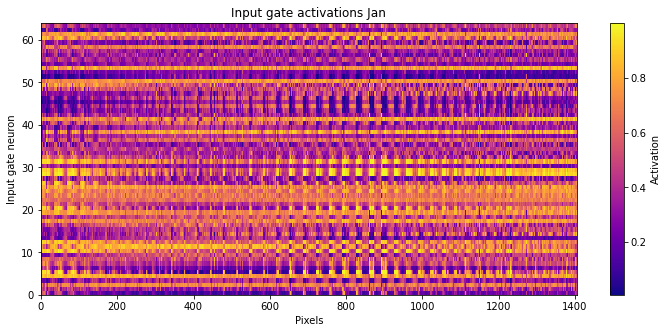

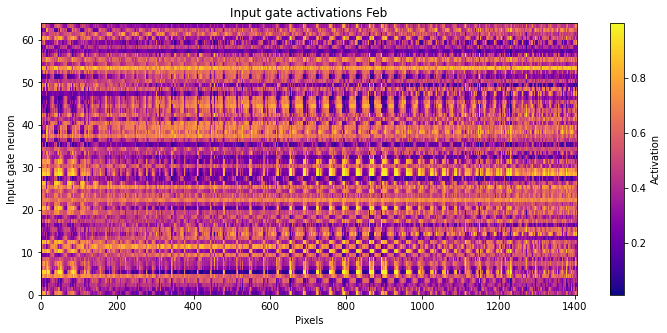

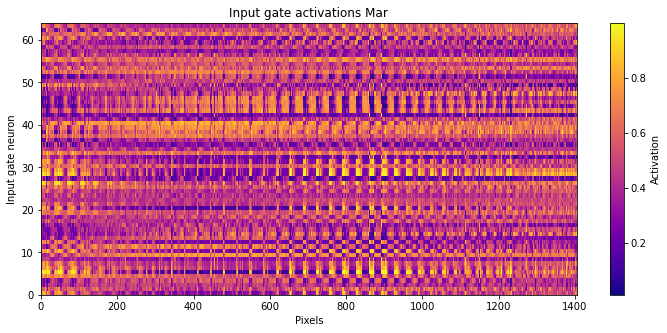

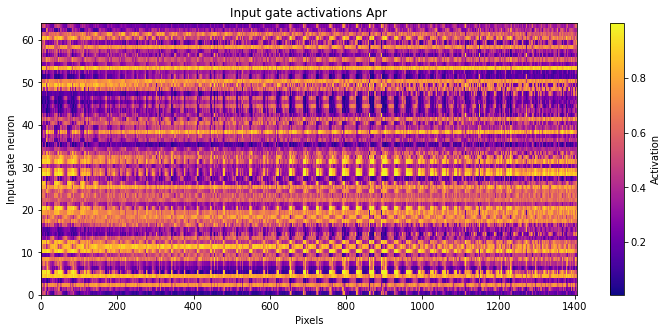

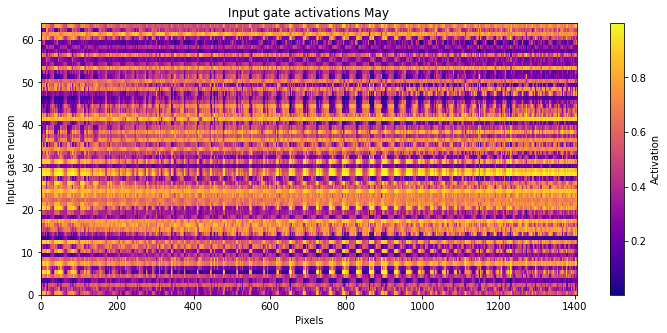

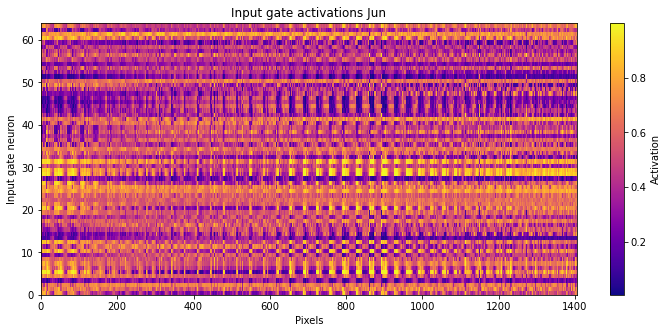

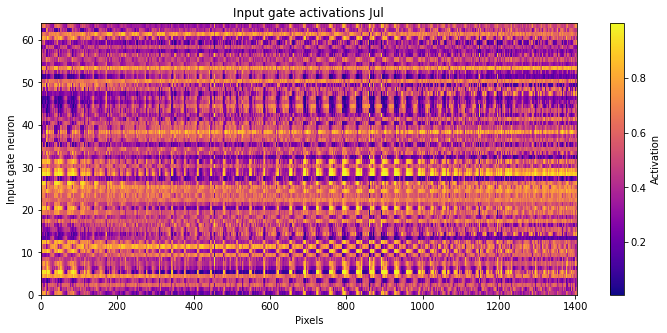

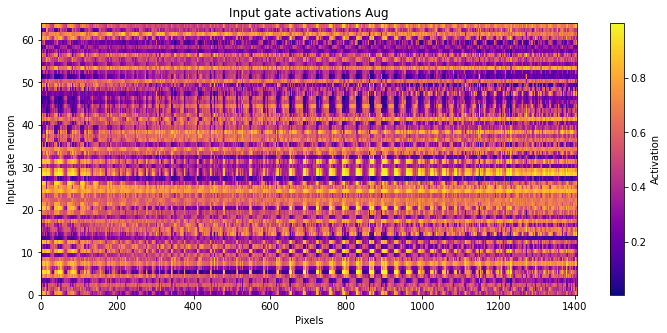

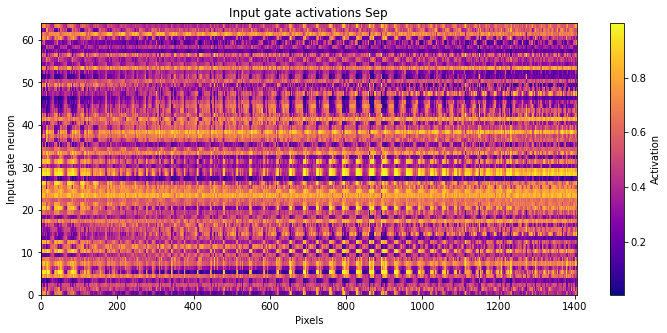

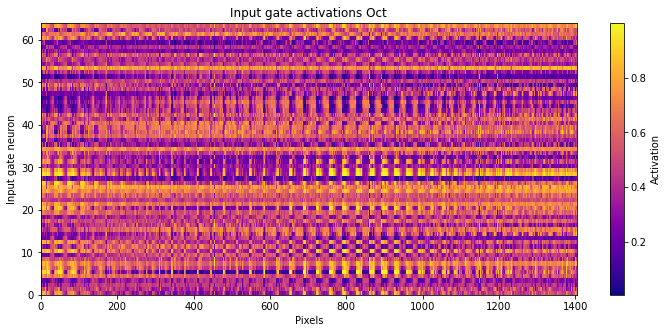

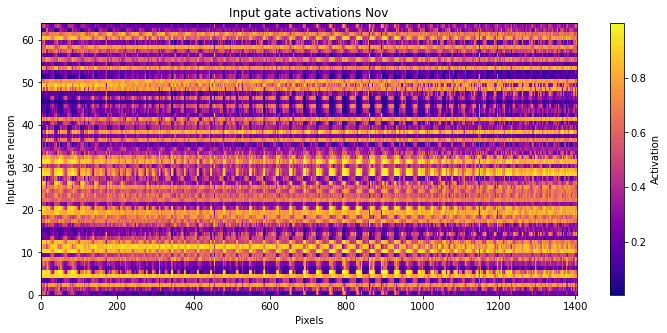

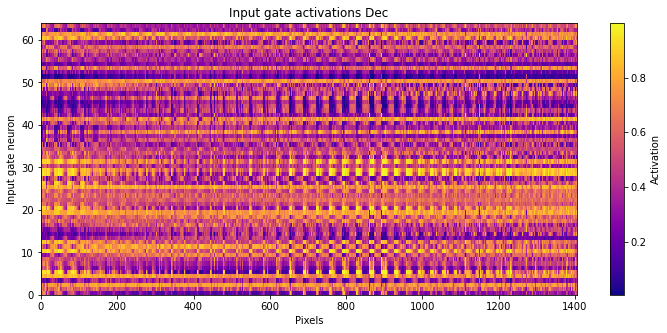

In [25]:
import calendar

for embedding, pred_month in zip(month_embeddings, month_pred_months):
    # embedding = all_embeddings[0]
    fig, ax = plt.subplots(figsize=(12,5))
    img = ax.pcolor(embedding.T, cmap='plasma')
    ax.set_xlabel("Pixels")
    ax.set_ylabel("Input gate neuron")
    month = [m for m in calendar.month_abbr][pred_month]
    ax.set_title(f"Input gate activations {month}")
    cbar = plt.colorbar(img, ax=ax)
    cbar.ax.set_ylabel("Activation")

In [26]:
# create embedding dataset
def build_xarray_object(embedding_matrix: np.array, ix):
    return (
        pd.DataFrame(embedding_matrix)
        .reset_index()
        .rename(columns={'index': 'pixel'})
        .melt(id_vars='pixel')
        .rename(columns={'variable': 'neuron', 'value': f'activation_{ix:03d}'})
        .set_index(['pixel', 'neuron'])
        .to_xarray()
    )

all_ds = []
for ix, embedding_matrix in enumerate(all_e):
    all_ds.append(build_xarray_object(embedding_matrix, ix))
    break
    
ds = xr.auto_combine(all_ds)
ds

<xarray.Dataset>
Dimensions:         (neuron: 64, pixel: 1404)
Coordinates:
  * pixel           (pixel) int64 0 1 2 3 4 5 ... 1398 1399 1400 1401 1402 1403
  * neuron          (neuron) int64 0 1 2 3 4 5 6 7 8 ... 56 57 58 59 60 61 62 63
Data variables:
    activation_000  (pixel, neuron) float64 0.4045 0.6835 ... 0.3171 0.7132

# How does this vary over each MONTH ?

In [42]:
# Taken directly from Kratzert et al (2019) 
# https://github.com/kratzert/ealstm_regional_modeling/blob/master/papercode/clusterutils.py
from collections import defaultdict
from typing import List, Dict, Union
from sklearn.cluster import KMeans


def fit_kmeans(
    array: np.array, 
    ks: List[int] = [4],
    init_array: Optional[np.ndarray] = None,
) -> Dict[int, Dict[int, int]]:
    # initialise the output dictionary
    clusters = {k: {} for k in ks}
    
    for k in ks:
        if init_array is not None:
            assert init_array.shape[0] == k, "First dimension should be "
            clusterer = KMeans(
                n_clusters=k, random_state=0, init=init_array, n_init=1
            ).fit(array)
        else:
            clusterer = KMeans(
                n_clusters=k, random_state=0, init='k-means++', n_init=200
            ).fit(array)

        for pixel in range(array.shape[0]):
            arr = array[pixel, :]
            clusters[k][pixel] = clusterer.predict(arr.reshape(1, -1))[0]
    return clusters


def convert_clusters_to_ds(ks: List[int], static_clusters: Dict[int, np.array], pixels: np.ndarray, latitudes: np.ndarray, longitudes: np.ndarray, time: Union[pd.Timestamp, int] = 1) -> xr.Dataset:
    out = []
    for k in ks:
        cluster = np.array([v for v in static_clusters[k].values()])
        coords = {'pixel': pixels}
        dims = ['pixel']
        cluster_ds = xr.Dataset(
            {
                f'cluster_{k}': (dims, cluster), 
                'lat': (dims, latitudes), 
                'lon': (dims, longitudes), 
                'time': (dims, [time for _ in range(len(latitudes))]),
            }
        )
        out.append(cluster_ds)
    
    static_cluster_ds = xr.auto_combine(out)
    static_cluster_ds = static_cluster_ds.to_dataframe().set_index(['time', 'lat','lon']).to_xarray()
    
    return static_cluster_ds


def plot_cluster_ds(ks: List[int], static_cluster_ds: xr.Dataset, cmap=None, month_abbr: str = ''):
    for k in ks:
        fig, ax = plt.subplots(figsize=(12,8))
        static_cluster_ds[f'cluster_{k}'].plot(ax=ax, cmap=cmap)
        ax.set_title(f'Output of Static Embedding Clustering [k={k}]\n{month_abbr}');

        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]): # + ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(20)

In [34]:
month_embeddings[0].shape

(1404, 64)

In [35]:
# len(all_e)
# embedding.shape
# latlons.shape

print(len(month_embeddings))
print(len(month_pred_months))
print(len(month_latlons))

12
12
12


In [36]:
month_embeddings[0]

array([[0.40453181, 0.68348686, 0.70723824, ..., 0.87456559, 0.0892851 ,
        0.57631769],
       [0.40741658, 0.73145329, 0.694651  , ..., 0.81892076, 0.08185695,
        0.58810039],
       [0.42435264, 0.72693297, 0.69883484, ..., 0.80442917, 0.0906345 ,
        0.5893139 ],
       ...,
       [0.4644778 , 0.55703256, 0.64040095, ..., 0.70959442, 0.32966904,
        0.69006944],
       [0.45269931, 0.2672206 , 0.35025521, ..., 0.61882678, 0.30134011,
        0.70458538],
       [0.40164009, 0.50413422, 0.52049179, ..., 0.7234353 , 0.31707318,
        0.7132474 ]])

In [43]:
# n clusters 

# calculate clusters for ALL x.nc inputs
all_cluster_ds = []

# ks = [5]
# init = np.random.random(ks[0], 64)

for ix, (embedding, pred_month, latlons) in enumerate(zip(
    month_embeddings, 
    month_pred_months, 
    month_latlons
)):
    ks = [5]
    # fit the clusters
    static_clusters = fit_kmeans(embedding, ks)
    print(f"Fitted KMeans {ix}") if ix % 10 == 0 else None
    
    # convert to dataset
    pixels = latlons
    lons = latlons[:, 1] 
    lats = latlons[:, 0] 
    static_cluster_ds = convert_clusters_to_ds(ks, static_clusters, pixels, lats, lons, time=ix)
    print(f"Convert to ds {ix}") if ix % 10 == 0 else None
    
    # append to final list
    all_cluster_ds.append(static_cluster_ds)

# combine into one xr.Dataset
cluster_ds = xr.auto_combine(all_cluster_ds)

Fitted KMeans 0
Convert to ds 0
Fitted KMeans 10
Convert to ds 10


In [38]:
cluster_ds

<xarray.Dataset>
Dimensions:    (lat: 45, lon: 35, time: 12)
Coordinates:
  * lat        (lat) float64 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.25 5.5 5.75 6.0
  * lon        (lon) float64 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    cluster_5  (time, lat, lon) float64 3.0 3.0 0.0 3.0 3.0 ... 2.0 2.0 2.0 2.0

In [39]:
if not (data_dir / f"tommy/static_embeddings.nc").exists():
    cluster_ds.to_netcdf(data_dir / f"tommy/static_embeddings.nc")
else:
    print(f"Already saved to: {(data_dir / 'tommy/static_embeddings.nc').as_posix()}")

Already saved to: data/tommy/static_embeddings.nc


# Plot KMeans for each of the embeddings

### Raw plotting (no matching of the groups)

KeyboardInterrupt: 

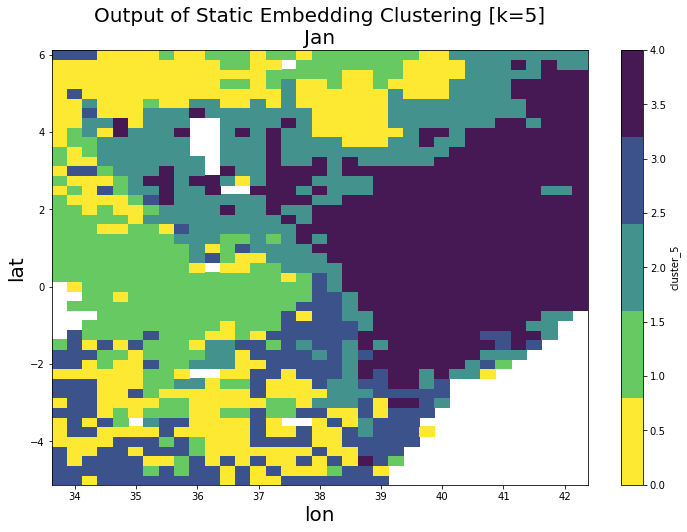

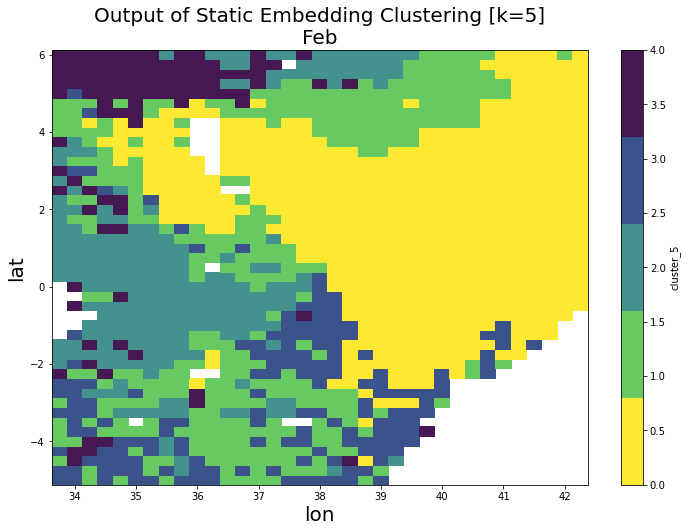

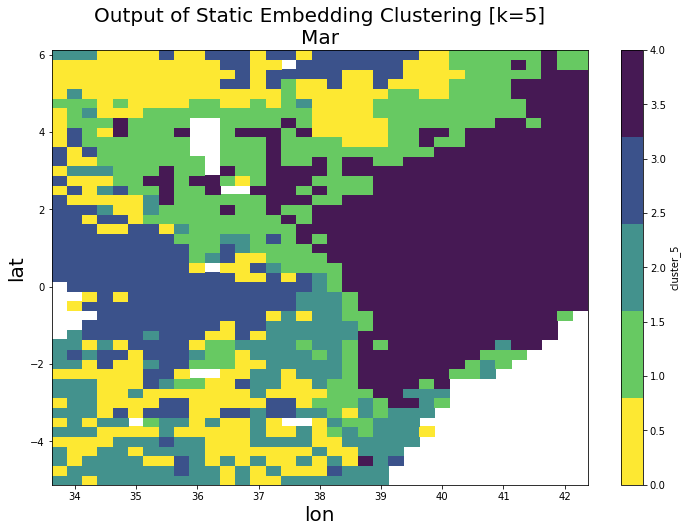

In [129]:
m_abbrs = [m for m in calendar.month_abbr]
colors = np.array(['#fde832', '#67c962', '#43928d', '#3b528b', '#461954'])
cmap = ListedColormap(colors)

for embedding, pred_month, latlons in zip(
    month_embeddings, 
    month_pred_months, 
    month_latlons
):
    ks = [5]
    static_clusters = fit_kmeans(embedding, ks)
    
    # create ds
    pixels = latlons
    lons = latlons[:, 1] 
    lats = latlons[:, 0] 
    static_cluster_ds = convert_clusters_to_ds(ks, static_clusters, pixels, lats, lons)
    
    # plot ds
    month_abbr = m_abbrs[pred_month]
    plot_cluster_ds(ks, static_cluster_ds, month_abbr=month_abbr, cmap=cmap)

### Matching the Groups to make sure colors align

In [ ]:
from matplotlib.colors import ListedColormap

# colors = sns.color_palette('viridis', 6)
#                   yellow,    green,    turqoise,   blue,      purple
colors = np.array(['#fde832', '#67c962', '#43928d', '#3b528b', '#461954'])
cmap = ListedColormap(colors)

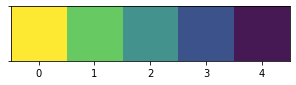

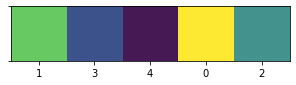

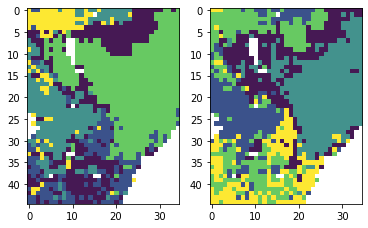

In [125]:
jan = cluster_ds.isel(time=0).cluster_5
mar = cluster_ds.isel(time=2).cluster_5
may = cluster_ds.isel(time=4).cluster_5
jun = cluster_ds.isel(time=5).cluster_5
aug = cluster_ds.isel(time=8).cluster_5
oct = cluster_ds.isel(time=10).cluster_5

comparison_ds = may
reference_ds = jan

remapping = [1, 3, 4, 0, 2]

sns.palplot(colors)
ax = plt.gca()
ax.set_xticks([i for i in range(0, 5)])
ax.set_xticklabels([i for i in range(0, 5)])

sns.palplot(colors[remapping])
ax = plt.gca()
ax.set_xticks([i for i in range(0, 5)])
ax.set_xticklabels(remapping)

new_cmap = ListedColormap(colors[np.array(remapping)])

fig, axs = plt.subplots(1, 2)
axs[0].imshow(comparison_ds.values[::-1, :], cmap=cmap)
axs[1].imshow(reference_ds.values[::-1, :], cmap=new_cmap)

selecting region: coastal from ds
selecting region: coastal from ds
selecting region: victoria from ds
selecting region: victoria from ds
selecting region: nw_pastoral from ds
selecting region: nw_pastoral from ds
selecting region: kitui from ds
selecting region: kitui from ds
selecting region: turkana_edge from ds
selecting region: turkana_edge from ds
dict_values([0.0, 4.0, 1.0, 3.0, 2.0])


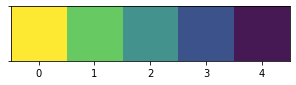

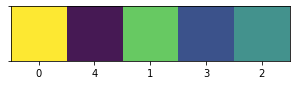

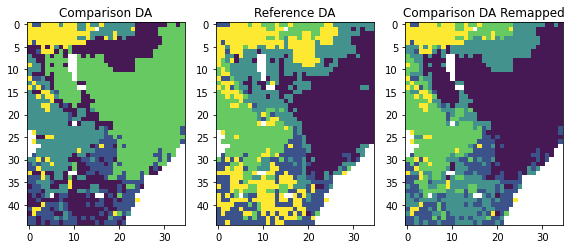

In [325]:
from matplotlib.colors import ListedColormap
colors = np.array(['#fde832', '#67c962', '#43928d', '#3b528b', '#461954'])



def get_matching_groups(
    reference_ds: xr.DataArray, comparison_ds: xr.DataArray,
    percent: bool = True, regions: Optional[List[Region]] = None,
) -> Tuple[Dict[float, float], pd.DataFrame]:
    # get the unique values from the reference_ds
    group_vals = np.unique(reference_ds.values[~np.isnan(reference_ds.values)])
    
    if regions is not None:
        df = count_mappings_for_regions(reference_ds, comparison_ds, regions)
        remap_dict = match_by_region_algorithm(df, regions)
        
    else:
        # calculate the number of matching pixels
        df = convert_counts_dict_to_dataframe(
            count_matching_pixels(reference_ds, comparison_ds)
        )

        # calculate_the remap_dict
        remap_dict = most_overlapping_pixels_algorithm(df, percent=percent)

    # check that the groups are matching / all groups are included
    assert all(np.isin(np.unique(df['reference_group'].values), group_vals))
    assert all(np.isin(np.unique(df['comparison_group'].values), group_vals))

    # check all values in group_vals are in the dict keys
    assert all(np.isin([k for k in remap_dict.keys()], group_vals))

    return remap_dict, df


def count_matching_pixels(reference_ds: xr.Dataset, comparison_ds: xr.Dataset) -> Dict[float, Dict[float, float]]:
    """Count the number of pixels for each value
        in comparison_ds for each reference value
        in reference_ds

    Returns:
    -------
     Dict[float, Dict[float, float]]
        keys = reference_ds values "group_0"
        values = {comparison_ds values: count of matches} "group_1"
    """
    unique_counts = dict()

    # for each reference value in reference_ds
    # excluding np.nan
    for value in np.unique(reference_ds.values[~np.isnan(reference_ds.values)]):
        # get the pixels from Comparison corresponding to `value` in Reference
        np_arr = comparison_ds.where(reference_ds == value).values
        # drop nans from matching values
        np_arr = np_arr[~np.isnan(np_arr)]
        # calculate the number of group_1 pixels
        counts = np.unique(np_arr, return_counts=True)
        unique_counts[value] = dict(zip(counts[0], counts[1]))

    return unique_counts


def convert_counts_dict_to_dataframe(unique_counts: dict) -> pd.DataFrame:
    """create long format dataframe from counts in unique_counts
    reference_ds = group_0
    comparison_ds = group_1
    """
    df = pd.DataFrame(unique_counts)  # rows = group_1_values, cols = group_0_values
    df.columns = df.columns.rename('reference_group')
    df.index = df.index.rename('comparison_group')
    # 2D -> 1D idx, group_0, group_1, count
    df = df.unstack().reset_index().rename(columns={0:'count'})

    counts = df.groupby('comparison_group')['count'].sum()
    df['pct'] = df.apply(lambda x: x['count'] / counts.loc[x['comparison_group']], axis=1)

    return df


def get_max_count_row(df: pd.DataFrame) -> pd.Series:
    """Get the row with the largest count from df"""
    return df.loc[df['count'].idxmax()]


def get_max_percent_row(df: pd.DataFrame) -> pd.Series:
    """Get the row with the highest percentage overlap"""
    return df.loc[df['pct'].idxmax()]


def coarsen_da(ds: xr.Dataset, rolling_size: int = 3) -> xr.Dataset:
    # return ds.coarsen(lat=5, lon=5).median()
    return ds.rolling(lat=rolling_size).median().rolling(lon=rolling_size).median()


def drop_already_assigned_values(
    df: pd.DataFrame,
    assigned_group_values: List[float],
) -> pd.DataFrame:
    """drop the values that have been assigned (added to the lists)
    """
    # remove the matches from group_1 / comparison_group
    df = df.loc[~np.isin(df['comparison_group'], assigned_group_values)]
    # remove the matches from group_0 / reference_group
    df = df.loc[~np.isin(df['reference_group'], assigned_group_values)]
    return df


def calculate_remap_dict(reference_group_list: List[float], comparison_group_list: List[float]) -> Dict[float, float]:
    """create dictionary object containing the mapping from reference_group -> comparison_group"""
    remap_dict = dict()
    # TODO: Tis assumption is not true it's not symmetrical
    # remap dict is symmetrical:
    # values in group_0->group_1 are the same mapping as group_1 -> group_0
    remap_dict.update(dict(zip(reference_group_list, comparison_group_list)))
    remap_dict.update(dict(zip(remap_dict.values(), remap_dict.keys())))

    # sort the remap_dict
    remap_dict = {k :remap_dict[k] for k in sorted(remap_dict)}

    return remap_dict


def most_overlapping_pixels_algorithm(df: pd.DataFrame, percent: bool = True) -> Dict[float, float]:
    """match the 'closest' group from reference_group_list in comparison_group_list"""
    
    assert all(
        np.isin(["reference_group", "comparison_group"], [c for c in df.columns])
    ), f"Need columns reference_group comparison_group. Found: {df.columns}"
    # get the counts of each pixel value/group (excl. nans) and select the most cross-overs (by percentages)
    # order is important so we do the BEST match first
    # get the largest first
    reference_group_list = []
    comparison_group_list = []

    # match each reference_group to closest matching comparison_group
    # track progress by removing the matches that have already been made
    # from the dataframe
    while df.shape[0] > 0:
        # IF only one group-value left, assign it to the final remaining group (itself)
        if len(df['comparison_group'].unique()) == 1:
            # final value is itself
            # remap_dict[df['comparison_group'].unique()[0]] = df['comparison_group'].unique()[0]
            reference_group_list.append(df['comparison_group'].unique()[0])
            comparison_group_list.append(df['comparison_group'].unique()[0])
            df = drop_already_assigned_values(
                df, reference_group_list + comparison_group_list
            )

        else:
            # otherwise match to the closest remaining match (most overlapping pixels)
            max_count_row = get_max_percent_row(df) if percent else get_max_count_row(df)
            reference_group_list.append(
                max_count_row['reference_group']
            )
            comparison_group_list.append(
                max_count_row['comparison_group']
            )

            # drop_already_assigned_values
            df = drop_already_assigned_values(
                df, reference_group_list+comparison_group_list
            )

    remap_dict = calculate_remap_dict(reference_group_list, comparison_group_list)

    return remap_dict

# --------------------------
# Region Algorithm
# --------------------------

def count_mappings_for_regions(reference_ds: xr.DataArray, comparison_ds: xr.DataArray, regions: List[str]) -> pd.DataFrame:
    all_df = []
    for region in regions:
        region_reference_ds = select_bounding_box(reference_ds.to_dataset(), region)[variable]
        region_comparison_ds = select_bounding_box(comparison_ds.to_dataset(), region)[variable]
        
        # count the pixels in each group
        d = convert_counts_dict_to_dataframe(
            count_matching_pixels(region_reference_ds, region_comparison_ds)
        )
        d['region'] = [region.name for _ in range(len(d))]
        all_df.append(d)

    all_df = pd.concat(all_df)
    
    return all_df


def match_by_region_algorithm(all_df: pd.DataFrame, regions: List[str]) -> Dict[float, float]:
    """ Use predefined Region objects to subset the spatial maps and
    run the maximum count algorithm to map the groupings for these specific
    areas across months!
    """
    assert all(
        np.isin(["reference_group", "comparison_group"], [c for c in all_df.columns])
    ), f"Need columns reference_group comparison_group. Found: {all_df.columns}"

    reference_group_list = []
    comparison_group_list = []

    for region in regions:
        region_name = region.name

        # IF only one group-value left, assign it to the final remaining group (itself)
        if len(all_df['comparison_group'].unique()) == 1:
            # final value is itself
            # remap_dict[df['comparison_group'].unique()[0]] = df['comparison_group'].unique()[0]
            reference_group_list.append(all_df['reference_group'].unique()[0])
            comparison_group_list.append(all_df['comparison_group'].unique()[0])
            all_df = drop_already_assigned_values(
                all_df, reference_group_list + comparison_group_list
            )
        else:
            region_df = all_df.query(f"region == '{region_name}'")

            max_count_row = get_max_count_row(region_df)

            # save the mapping
            reference_group_list.append(
                max_count_row['reference_group']
            )
            comparison_group_list.append(
                max_count_row['comparison_group']
            )

            # drop_already_assigned_values
            all_df = all_df.loc[~np.isin(all_df['comparison_group'], comparison_group_list)]
            all_df = all_df.loc[~np.isin(all_df['reference_group'], reference_group_list)]


    remap_dict = calculate_remap_dict(reference_group_list, comparison_group_list)

    return remap_dict


# Plotting helper functions
def plot_colors_remapping(colors, remap_dict) -> None:
    colors_remapped = [[int(v) for v in remap_dict.values()]]
    sns.palplot(colors)
    sns.palplot(colors_remapped)



def plot_comparisons(
    reference_da: xr.DataArray, comparison_da: xr.DataArray,
    colors: List[str], remapping_dict: Dict[int, int], 
    title: Optional[str] = None
) -> None:
    """check that the remapping is sensible"""
    # convert to numpy array
    remapping_list = np.array([int(k) for k in remap_dict.values()])
    
    # plot the colormaps 
    sns.palplot(colors)
    ax = plt.gca()
    ax.set_xticks([i for i in range(0, 5)])
    ax.set_xticklabels([i for i in range(0, 5)])
    if title is not None:
        ax.set_title(title)
    sns.palplot(np.array(colors)[remapping_list])
    ax = plt.gca()
    ax.set_xticks([i for i in range(0, 5)])
    ax.set_xticklabels(remapping_list)
    
    # create cmaps
    new_cmap = ListedColormap(colors[remapping_list])
    cmap = ListedColormap(colors)
    
    # plot the spatial patterns
    fig, axs = plt.subplots(1, 3, figsize=((6.4/2)*3, 4.8))
    axs[1].imshow(reference_da.values[::-1, :], cmap=cmap)
    axs[1].set_title('Reference DA')
    axs[0].imshow(comparison_da.values[::-1, :], cmap=cmap)
    axs[0].set_title('Comparison DA')
    axs[2].imshow(comparison_da.values[::-1, :], cmap=new_cmap)
    axs[2].set_title('Comparison DA Remapped')

# remap_dict, matches_df = get_matching_groups(reference_ds, comparison_ds)
jan = cluster_ds.isel(time=0).cluster_5
may = cluster_ds.isel(time=4).cluster_5

comparison_ds = may
reference_ds = jan

remap_dict, df = get_matching_groups(reference_ds, comparison_ds, regions=regions)
remap_dict.values()

print(remap_dict.values())

## CHECK that the remapping is sensible!
plot_comparisons(
    reference_ds, comparison_ds,
    colors=colors,
    remapping_dict=remap_dict,
    title=None
)

# new_var = remap_xarray_values(comparison_ds, remap_dict, new_variable='cluster_5', overwrite=True)
# fig, ax = plt.subplots()
# new_var.plot(cmap=cmap, ax=ax)

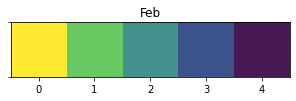

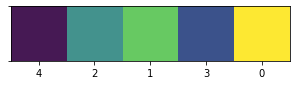

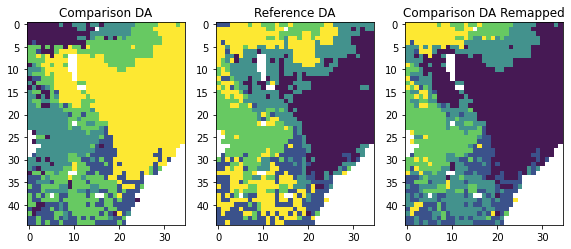

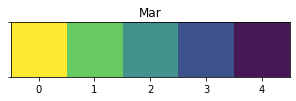

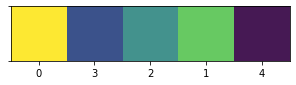

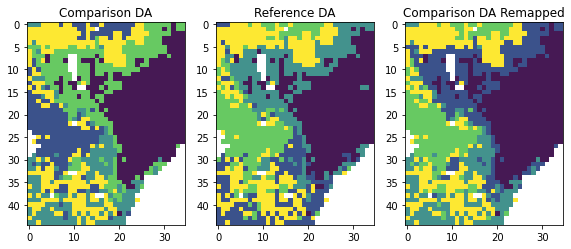

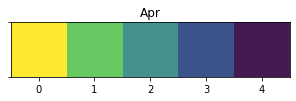

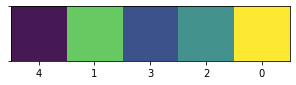

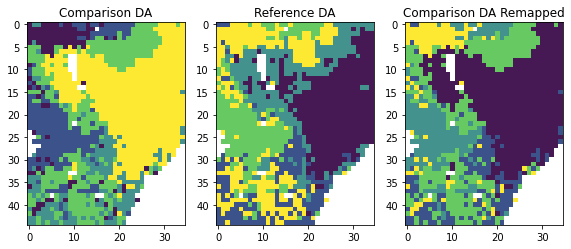

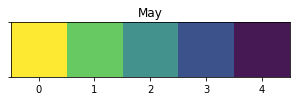

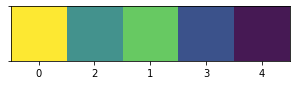

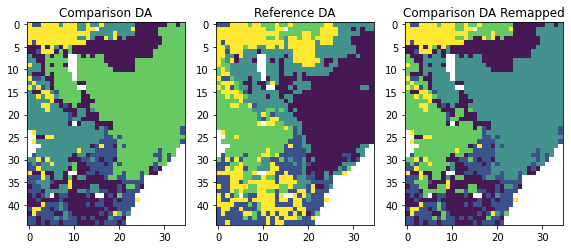

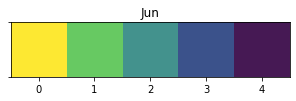

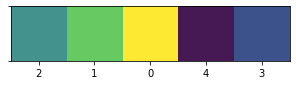

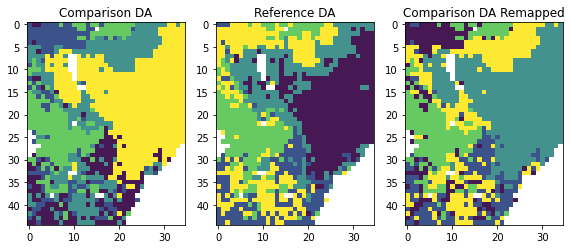

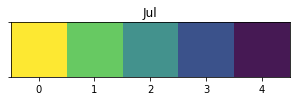

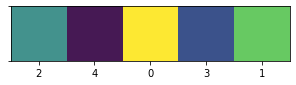

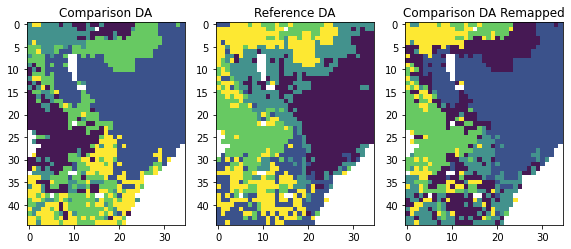

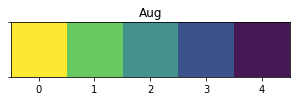

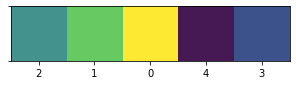

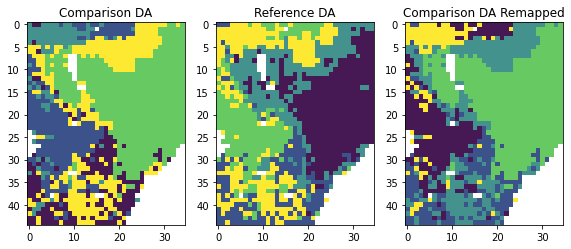

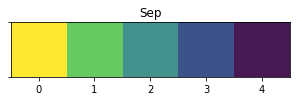

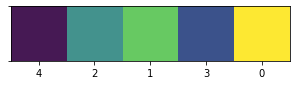

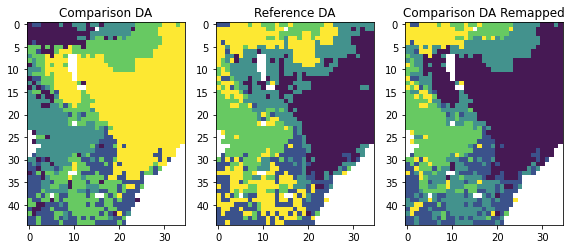

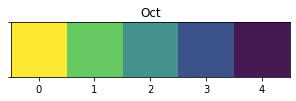

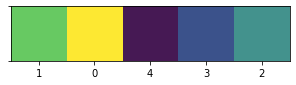

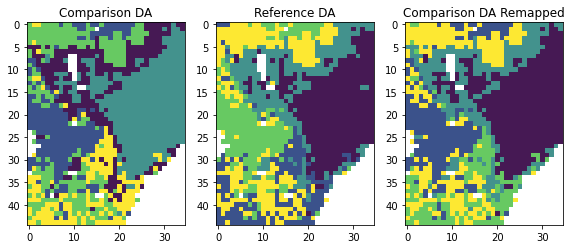

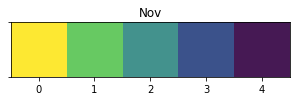

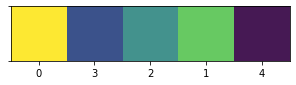

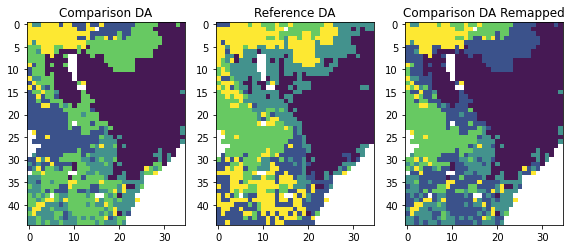

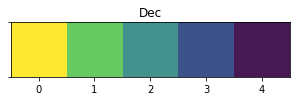

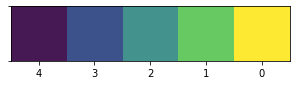

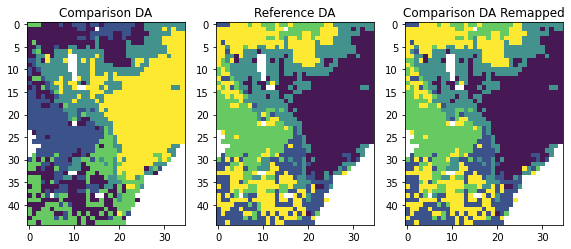

In [124]:
jan = cluster_ds.isel(time=0).cluster_5
reference_da = jan

for mth in range(1, 12):
    comparison_ds = cluster_ds.isel(time=mth).cluster_5
    remap_dict, matches_df = get_matching_groups(reference_ds, comparison_ds, percent=True)
    plot_comparisons(
        reference_ds, comparison_ds,
        colors=colors,
        remapping_dict=remap_dict,
        title=calendar.month_abbr[mth+1]
    )


# Do the matching on specific areas:
- most common in specific areas
- Order is important
- 1) Coastal is most easy to gather
- 2) Victoria is next simplest
- 3) NW Pastoral is the next best
- 4) Kitui is next
- 5) Turkana edge is most uncertain (whichever group is left)

In [333]:
"""
np.array([
    [latmax, lonmin], = upper left
    [latmin, lonmin], = lower left
    [latmin, lonmax], = lower right
    [latmax, lonmax], = upper right
])

area_bboxes = {
 'kitui': np.array([[24.15217473, 13.869984  ],
        [33.58862989, 13.869984  ],
        [33.58862989, 19.49874673],
        [24.15217473, 19.49874673]]),
 'victoria': np.array([[15.21237511, -0.30016743],
        [31.10535222, -0.30016743],
        [31.10535222, 12.61287647],
        [15.21237511, 12.61287647]]),
 'turkana_edge': np.array([[ 2.79598674, 14.5994986 ],
        [ 9.41806054, 14.5994986 ],
        [ 9.41806054, 29.3336128 ],
        [ 2.79598674, 29.3336128 ]]),
 'nw_pastoral': np.array([[-0.43227423, -0.45025058],
        [ 5.9414718 , -0.45025058],
        [ 5.9414718 , 12.87667293],
        [-0.43227423, 12.87667293]]),
 'coastal': np.array([[13.72240851, 20.90593741],
        [25.31103765, 20.90593741],
        [25.31103765, 34.31563684],
        [13.72240851, 34.31563684]])
}

"""
from src.utils import Region
from src.preprocess.utils import select_bounding_box

kitui = Region(
    name='kitui',
    lonmin=cluster_ds.isel(lon=13).lon.values,
    lonmax=cluster_ds.isel(lon=19).lon.values,
    latmin=cluster_ds.isel(lat=-34).lat.values,
    latmax=cluster_ds.isel(lat=-24).lat.values,
)
victoria = Region(
    name='victoria',
    lonmin=cluster_ds.isel(lon=0).lon.values,
    lonmax=cluster_ds.isel(lon=12).lon.values,
    latmin=cluster_ds.isel(lat=-31).lat.values,
    latmax=cluster_ds.isel(lat=-15).lat.values,
)
turkana_edge = Region(
    name='turkana_edge',
    lonmin=cluster_ds.isel(lon=14).lon.values,
    lonmax=cluster_ds.isel(lon=29).lon.values,
    latmin=cluster_ds.isel(lat=-9).lat.values,
    latmax=cluster_ds.isel(lat=-2).lat.values,
)
nw_pastoral = Region(
    name='nw_pastoral',
    lonmin=cluster_ds.isel(lon=0).lon.values,
    lonmax=cluster_ds.isel(lon=12).lon.values,
    latmin=cluster_ds.isel(lat=-6).lat.values,
    latmax=cluster_ds.isel(lat=-1).lat.values,
)
coastal = Region(
    name='coastal',
    lonmin=cluster_ds.isel(lon=21).lon.values,
    lonmax=cluster_ds.isel(lon=34).lon.values,
    latmin=cluster_ds.isel(lat=-25).lat.values,
    latmax=cluster_ds.isel(lat=-13).lat.values,
)

regions = [
    coastal,
    victoria,
    nw_pastoral,
    kitui,
    turkana_edge,
]

selecting region: coastal from ds
selecting region: victoria from ds
selecting region: nw_pastoral from ds
selecting region: kitui from ds
selecting region: turkana_edge from ds


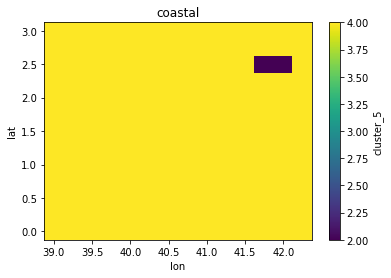

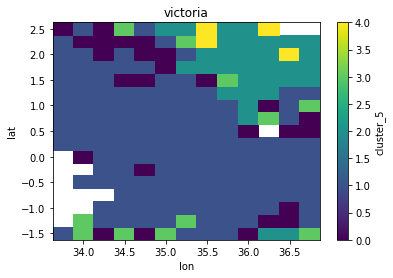

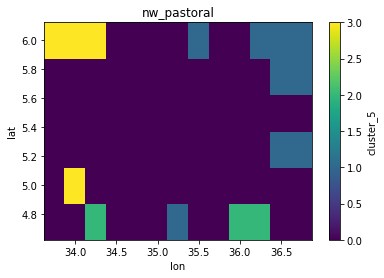

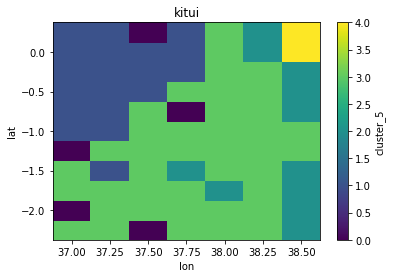

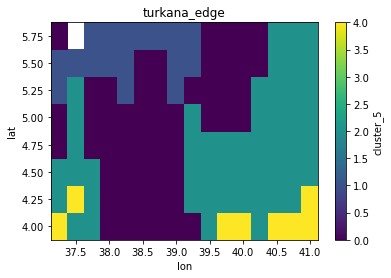

In [334]:
for region in regions:
    fig,ax=plt.subplots()
    select_bounding_box(cluster_ds, region).isel(time=0).cluster_5.plot(ax=ax)
    ax.set_title(f'{region.name}')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
selecting region: coastal from ds
selecting region: coastal from ds
selecting region: victoria from ds
selecting region: victoria from ds
selecting region: nw_pastoral from ds
selecting region: nw_pastoral from ds
selecting region: kitui from ds
selecting region: kitui from ds
selecting region: turkana_edge from ds
selecting region: turkana_edge from ds
selecting region: coastal from ds
selecting region: coastal from ds
selecting region: victoria from ds
selecting region: victoria from ds
selecting region: nw_pastoral from ds
selecting region: nw_pastoral from ds
selecting region: kitui from ds
selecting region: kitui from ds
selecting region: turkana_edge from ds
selecting region: turkana_edge from ds
selecting region: coastal from ds
selecting region: coastal from ds
selecting region: victoria from ds
selecting region: victoria from ds
selecting region: nw_pastoral from ds
selecting region: nw_pas

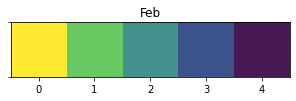

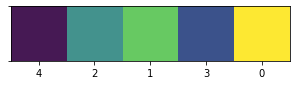

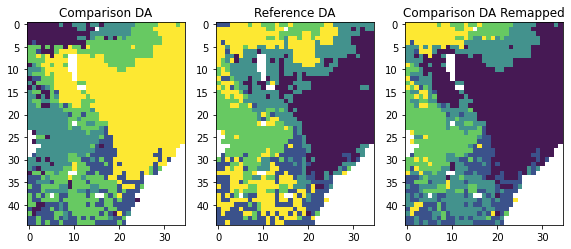

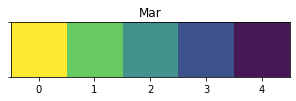

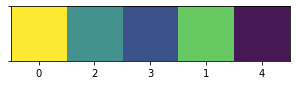

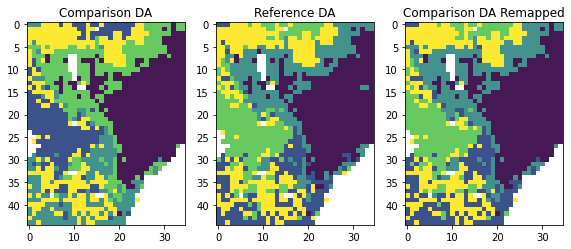

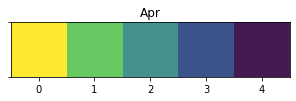

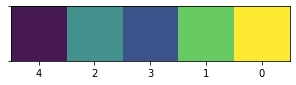

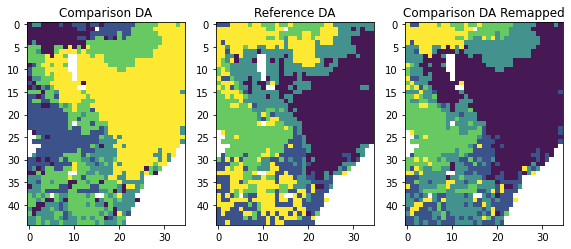

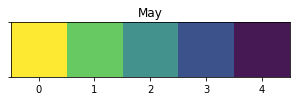

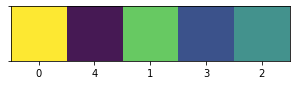

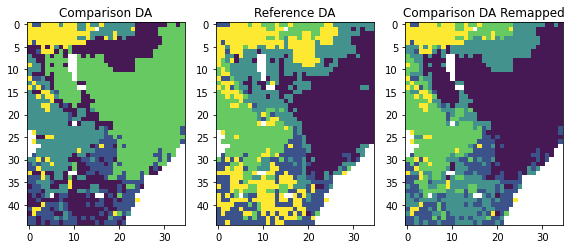

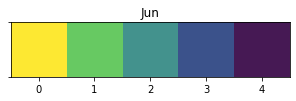

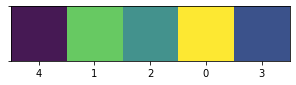

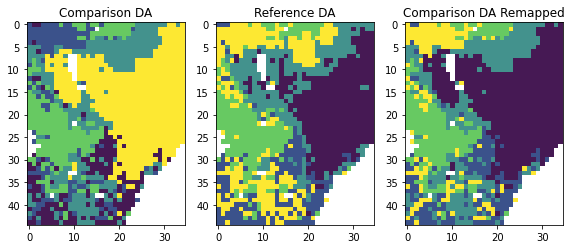

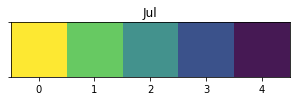

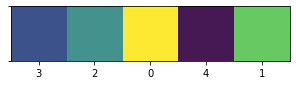

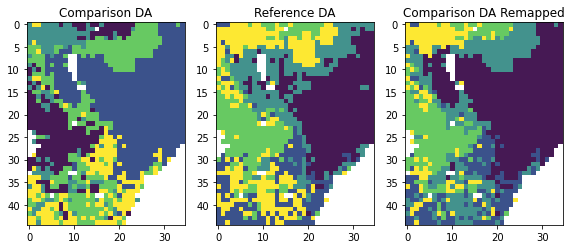

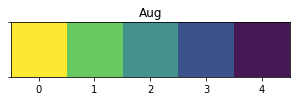

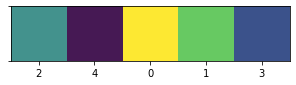

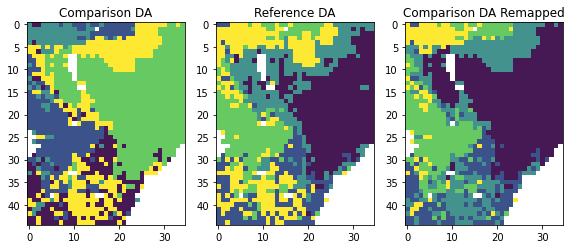

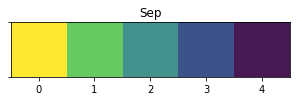

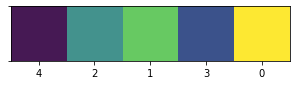

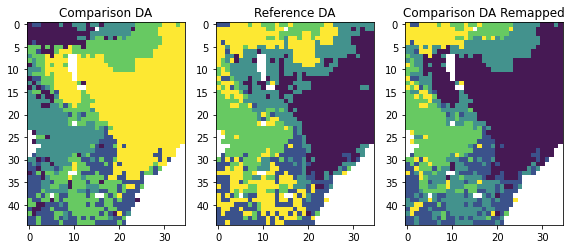

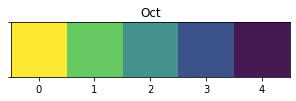

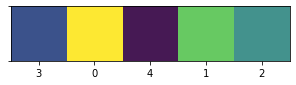

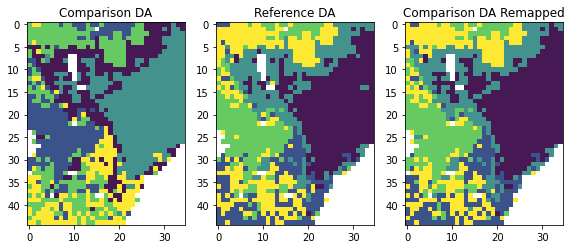

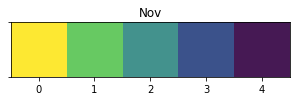

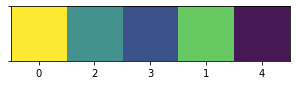

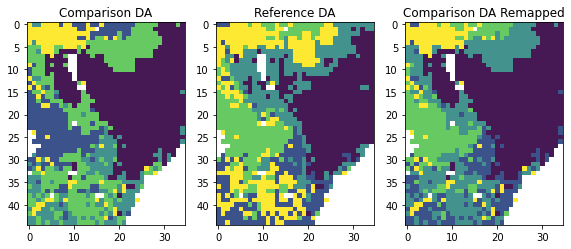

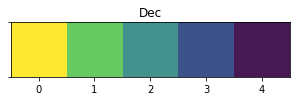

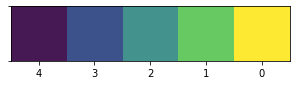

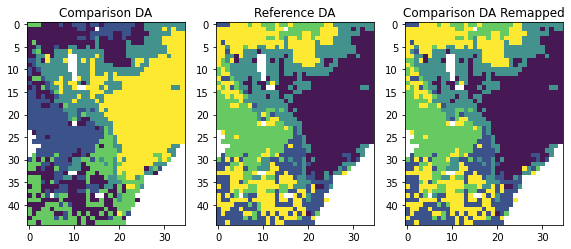

In [328]:
jan = cluster_ds.isel(time=0).cluster_5
reference_da = jan

for mth in range(1, 12):
    comparison_ds = cluster_ds.isel(time=mth).cluster_5
    remap_dict, matches_df = get_matching_groups(reference_ds, comparison_ds, regions=regions)
    plot_comparisons(
        reference_ds, comparison_ds,
        colors=colors,
        remapping_dict=remap_dict,
        title=calendar.month_abbr[mth+1]
    )

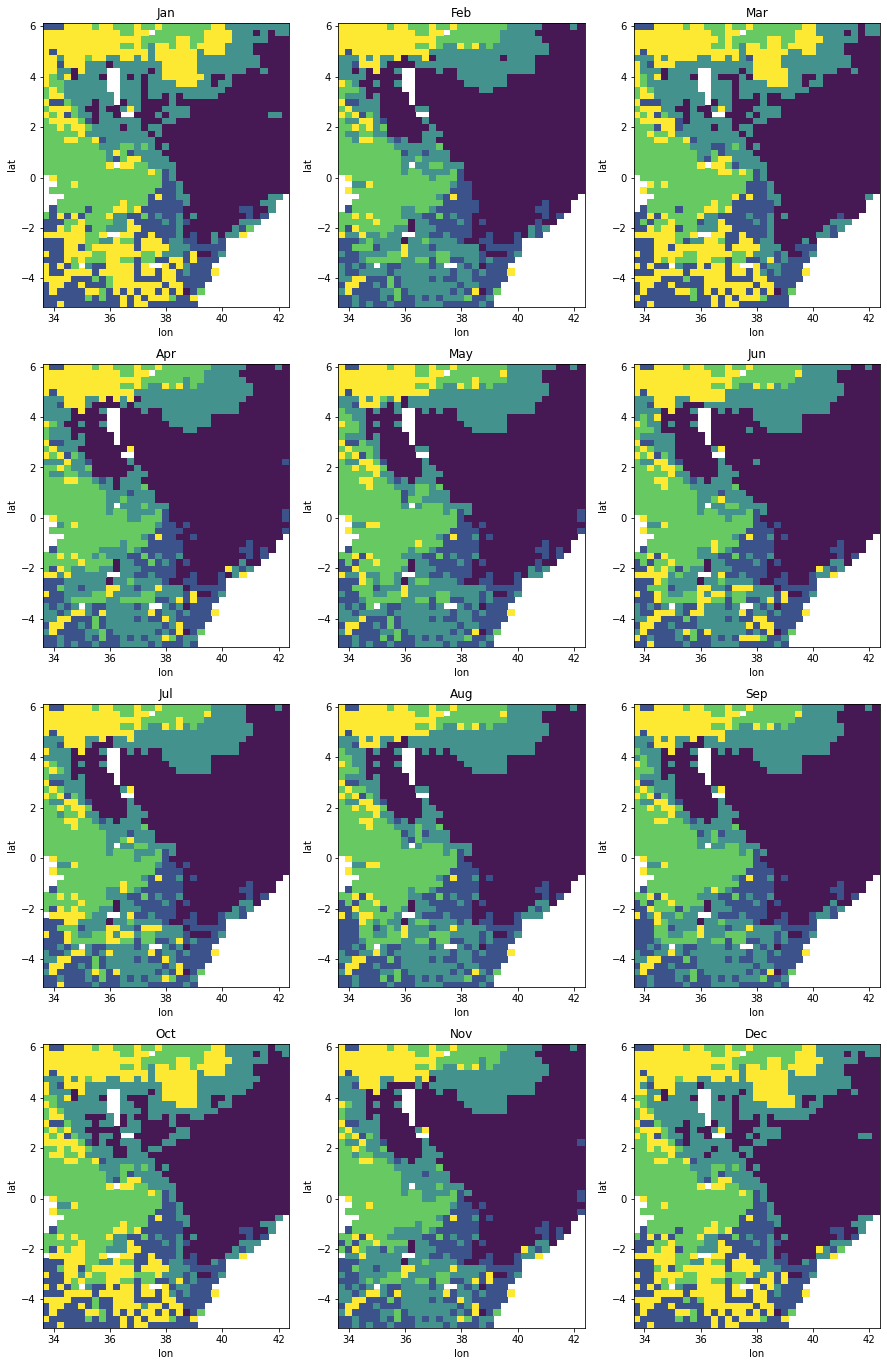

In [345]:
jan = cluster_ds.isel(time=0).cluster_5
reference_da = jan

fig, axs = plt.subplots(4, 3, figsize=(15, 8*3))

cmap = ListedColormap(colors)
reference_da.plot(
    ax=axs[0, 0], add_colorbar=False, cmap=cmap
)
axs[0, 0].set_title(calendar.month_abbr[1])

for mth in range(1, 12):
    ax = axs[np.unravel_index(mth, (4, 3))]
    comparison_ds = cluster_ds.isel(time=mth).cluster_5
    remap_dict, matches_df = get_matching_groups(reference_ds, comparison_ds, regions=regions)
    new_cmap = ListedColormap(colors[np.array([int(i) for i in remap_dict.values()])])
    comparison_ds.plot(
        add_colorbar=False, ax=ax, cmap=new_cmap
    )
    ax.set_title(calendar.month_abbr[mth+1])

In [335]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(all_df)

In [317]:
# region_ix = 1

# # reference_das
# fig, axs = plt.subplots(1, 2, figsize=(10,4))
# reference_das[region_ix].plot(ax=axs[0])
# comparison_das[region_ix].plot(ax=axs[1])

# MARGINALIA

### choosing the color 


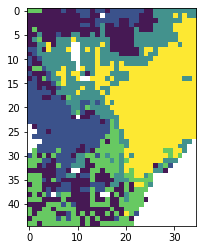

In [45]:
# ?ax.imshow
# https://stackoverflow.com/a/52323085/9940782
# https://stackoverflow.com/a/9708079/9940782
from matplotlib.colors import ListedColormap

# colors = sns.color_palette('viridis', 6)
#                   yellow,    green,    turqoise,   blue,      purple
colors = np.array(['#fde832', '#67c962', '#43928d', '#3b528b', '#461954'])
cmap = ListedColormap(colors)

## get the matching/closest embeddings
## assign a color to the values
fig, ax = plt.subplots()
k_matrix = cluster_ds.isel(time=-1).cluster_5.values[::-1, :]
ax.imshow(k_matrix, cmap=cmap)

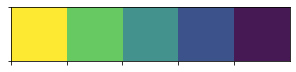

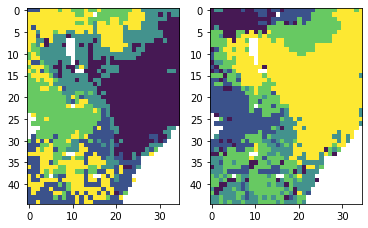

In [46]:
sns.palplot(colors)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(cluster_ds.isel(time=0).cluster_5.values[::-1, :], cmap=cmap)
axs[1].imshow(cluster_ds.isel(time=3).cluster_5.values[::-1, :], cmap=cmap)

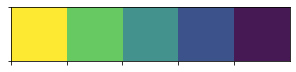

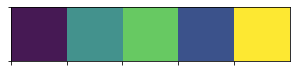

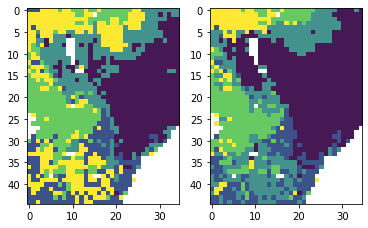

In [48]:
sns.palplot(colors)
sns.palplot(colors[[4, 2, 1, 3, 0]])

# {0.0: 4.0, 1.0: 2.0, 2.0: 1.0, 3.0: 3.0, 4.0: 0.0}
# 0->4, 1->2, 2->1, 3=3, 4->0
new_cmap = ListedColormap(colors[np.array([4, 2, 1, 3, 0])])

fig, axs = plt.subplots(1, 2)
axs[0].imshow(cluster_ds.isel(time=0).cluster_5.values[::-1, :], cmap=cmap)
axs[1].imshow(cluster_ds.isel(time=1).cluster_5.values[::-1, :], cmap=new_cmap)

In [51]:
group_0_list = []
group_1_list = []

group_vals = np.unique(reference_ds.values[~np.isnan(reference_ds.values)])
# calculate the number of matching pixels
df = convert_counts_dict_to_dataframe(
    count_matching_pixels(reference_ds, comparison_ds)
)

# check that the groups are matching / all groups are included
assert all(np.isin(np.unique(df.group_0.values), group_vals))
assert all(np.isin(np.unique(df.group_1.values), group_vals))

max_count_row = get_max_percent_row(df)
display(max_count_row)

# [0, 1 ,2 ,3 ,4]
# [1.0, 0.0, 4.0, 3.0, 2.0]
# [3, 0, 4, 1, 2]
display(df)

group_0      0.000000
group_1      4.000000
count      106.000000
pct          0.981481
Name: 3, dtype: float64

,group_0,group_1,count,pct
0,0.0,1.0,168.0,0.515337
1,0.0,2.0,15.0,0.063559
2,0.0,3.0,5.0,0.027778
3,0.0,4.0,106.0,0.981481
4,0.0,0.0,NaN,NaN
5,1.0,1.0,21.0,0.064417
6,1.0,2.0,217.0,0.919492
7,1.0,3.0,NaN,NaN
8,1.0,4.0,1.0,0.009259
9,1.0,0.0,NaN,NaN


In [ ]:
# group_0_list.append(df.group_1.unique()[0])
# group_1_list.append(df.group_1.unique()[0])

# df = drop_already_assigned_values(
#     df, group_1_list + group_0_list
# )
# display(df)
# max_count_row = get_max_percent_row(df)

# display(max_count_row)

# df = drop_already_assigned_values(
#     df, group_1_list + group_0_list
# )
# display(df)


In [53]:
assigned_group_values = []
display(matches_df.head(7))
display(matches_df.groupby('group_1')['count'].sum())

# 1.
# get matches
max_row = get_max_count_row(matches_df)
assigned_group_values += [max_row.group_1]
# drop_already_assigned_values
df = matches_df.loc[~np.isin(matches_df.group_1, assigned_group_values)]

# 2.
max_row = get_max_count_row(df)
assigned_group_values += [max_row.group_1]

,group_0,group_1,count,pct
0,0.0,0.0,1.0,0.001733
1,0.0,1.0,183.0,0.549550
2,0.0,2.0,11.0,0.048458
3,0.0,3.0,1.0,0.006061
4,0.0,4.0,98.0,0.960784
5,1.0,0.0,NaN,NaN
6,1.0,1.0,33.0,0.099099


group_1
0.0    577.0
1.0    333.0
2.0    227.0
3.0    165.0
4.0    102.0
Name: count, dtype: float64

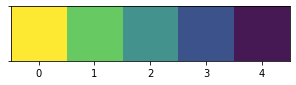

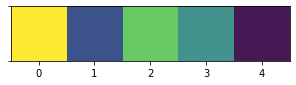

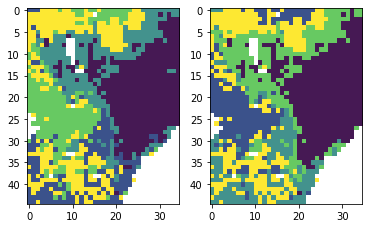

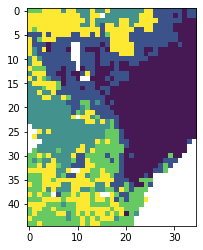

In [55]:
comparison_i = 2

_rm_dict = {0.0: 0.0, 1.0: 3.0, 2.0: 1.0, 3.0: 2.0, 4.0: 4.0}
colors_remapped = np.array(colors)[[int(v) for v in _rm_dict.values()]]

def plot_colormap(colors: List[str]):
    sns.palplot(colors)
    ax = plt.gca()
    ax.set_xticks(np.arange(5))
    ax.set_xticklabels(np.arange(5))
    
plot_colormap(colors)
plot_colormap(colors_remapped)

# 0->4, 1->2, 2->1, 3=3, 4->4
new_cmap = ListedColormap(colors_remapped)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(cluster_ds.isel(time=0).cluster_5.values[::-1, :], cmap=cmap)
axs[1].imshow(cluster_ds.isel(time=comparison_i).cluster_5.values[::-1, :], cmap=cmap)

fig, ax = plt.subplots()
ax.imshow(cluster_ds.isel(time=comparison_i).cluster_5.values[::-1, :], cmap=new_cmap)

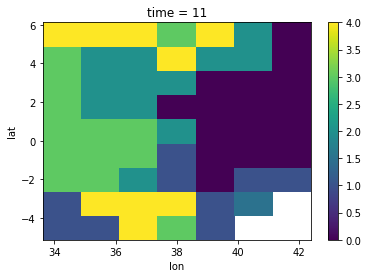

In [73]:
comparison_ds.coarsen(lat=5, lon=5).median().plot()

In [ ]:
# replace values using mapping defined in a dictionary

def replace_with_dict2(ar: np.array, dic: Dict) -> np.array:
    """Replace the values in an np.ndarray with a dictionary

    https://stackoverflow.com/a/47171600/9940782
    """
    # Extract out keys and values
    k = np.array(list(dic.keys()))
    v = np.array(list(dic.values()))

    # Get argsort indices
    sidx = k.argsort()

    ks = k[sidx]
    vs = v[sidx]
    warnings.warn("We are taking one from the index. need to check this is true!!!")
    return vs[np.searchsorted(ks, ar) - 1]


def remap_xarray_values(
    xr_obj: Union[xr.Dataset, xr.DataArray],
    lookup_dict: Dict,
    new_variable: str,
    overwrite: bool = True,
    variable: Optional[str] = None,
) -> Union[xr.Dataset, xr.DataArray]:
    """ remap values in xr_obj using lookup_dict.
    Arguments:
    ---------
    : xr_obj (xr.Dataset, xr.DataArray)
        the xarray object we want to look values up from
    : variable (str)
        the INPUT variable we are hoping to look the values up from (the dictionary keys)
    : new_variable (str)
        the name of the OUTPUT variable we want to put the dictionary values in
    : lookup_dict (dict)
        the dictionary we want to lookup the values of 'variable' in to return values to 'new_variable'
    : overwrite (bool)
        True = return a new xr_obj with the remapped values
        False = Assign a new Variable to the xr_obj
    """
    # get the values as a numpy array
    if isinstance(xr_obj, xr.Dataset):
        assert variable is not None
        assert variable in list(ds.data_vars), f"variable is not in {list(ds.data_vars)}"
        ar = xr_obj[variable].values
    elif isinstance(xr_obj, xr.DataArray):
        ar = xr_obj.values
    else:
        assert (
            False
        ), "This function only works with xarray objects." \
        f"Currently xr_obj is type: {type(xr_obj)}"

    assert isinstance(ar, np.ndarray), f"ar should be a numpy array!"
    assert isinstance(lookup_dict, dict), f"lookup_dict should be a dictionary object!"

    # replace values in a numpy array with the values from the lookup_dict
    new_ar = replace_with_dict2(ar, lookup_dict)

    # assign the values looked up from the dictionary to a new variable in the xr_obj
    new_da = xr.DataArray(new_ar, coords=[xr_obj.lat, xr_obj.lon], dims=["lat", "lon"])
    if new_variable is not None:
        new_da.name = new_variable
    if not overwrite:
        new_da = xr.merge([xr_obj, new_da])

    return new_da

In [ ]:
latitudes = latlons_data[:, 0]
longitudes = latlons_data[:, 1]
pixels = latlons

out = []
for k in ks:
    cluster = np.array([v for v in static_clusters[k].values()])
    coords = {'pixel': pixels}
    dims = ['pixel']
    cluster_ds = xr.Dataset({f'cluster_{k}': (dims, cluster), 'lat': (dims, latitudes), 'lon': (dims, longitudes),})
    out.append(cluster_ds)

static_cluster_ds = xr.auto_combine(out)
static_cluster_ds = static_cluster_ds.to_dataframe().set_index(['lat','lon']).to_xarray()

In [ ]:
# latitudes = latlons_data[:, 0]
# longitudes = latlons_data[:, 1]
pixels = latlons
convert_clusters_to_ds(ks, static_clusters=static_clusters, pixels=pixels)
pixels

### [UNNECESSARY] which of these neurons actually vary?

In [ ]:
threshold = 0.01

embedding = all_embeddings[0]
mask_same = np.all(np.isclose(embedding, embedding[0,:], threshold), axis=0)
print(f"How many neurons have the same values (thresh {threshold}): ".ljust(58), mask_same.sum())
print(f"How many neurons are left: ".ljust(58), len(mask_same) - mask_same.sum())
remove_constants = embedding[:, ~mask_same]

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
pd.DataFrame({'std': np.std(embedding, axis=0)}, index=np.arange(0, 64)).plot.bar(ax=ax)

plt.legend(fontsize=16)
ax.set_title('Variability of the Static Embedding')
ax.set_ylabel('Standard Deviation')
ax.set_xlabel('Neuron')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] # + ax.get_xticklabels()
              + ax.get_yticklabels()):
    item.set_fontsize(20)

### Remove the Non-Varying neurons

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
img = ax.pcolor(remove_constants.T, cmap='plasma')
ax.set_xlabel("Pixels")
ax.set_ylabel("Input gate neuron")
ax.set_title("Input gate activations")
cbar = plt.colorbar(img, ax=ax)
cbar.ax.set_ylabel("Activation")

# KMeans on the Embeddings

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
# Taken directly from Kratzert et al (2019) 
# https://github.com/kratzert/ealstm_regional_modeling/blob/master/papercode/clusterutils.py
from collections import defaultdict

ks = [3, 4, 5, 8]
clusters = {k: {} for k in ks}
for k in ks:
    clusterer = KMeans(n_clusters=k, random_state=0, init='k-means++',
                       n_init=200).fit(embedding)

    for pixel in range(embedding.shape[0]):
        emb = embedding[pixel, :]
        clusters[k][pixel] = clusterer.predict(emb.reshape(1, -1))[0]

In [ ]:
np.array([v for v in clusters[5].values()]).shape

In [ ]:
latitudes = latlons_data[:, 0]
longitudes = latlons_data[:, 1]
pixels = latlons

out = []
for k in ks:
    cluster = np.array([v for v in clusters[k].values()])
    coords = {'pixel': pixels}
    dims = ['pixel']
    cluster_ds = xr.Dataset({f'cluster_{k}': (dims, cluster), 'lat': (dims, latitudes), 'lon': (dims, longitudes),})
    out.append(cluster_ds)

cluster_ds = xr.auto_combine(out)
cluster_ds = cluster_ds.to_dataframe().set_index(['lat','lon']).to_xarray()

In [ ]:
for k in ks:
    fig, ax = plt.subplots(figsize=(12,8))
    cluster_ds[f'cluster_{k}'].plot(ax=ax)
    ax.set_title(f'Output of Static Embedding Clustering [k={k}]');

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]): # + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)

# Compare with the output of the raw static data 
(what info does the EALSTM embedding actually contribute?)

In [ ]:
print(static_x.shape)
print(embedding.shape)

In [ ]:
# Taken directly from Kratzert et al (2019) 
# https://github.com/kratzert/ealstm_regional_modeling/blob/master/papercode/clusterutils.py
from collections import defaultdict

ks = [3, 4, 5, 8]
# def fit_kmeans(array: np.array, ks: List[int] = [4]) -> Dict[int, Dict[int, int]]:
static_clusters = {k: {} for k in ks}
for k in ks:
    clusterer = KMeans(n_clusters=k, random_state=0, init='k-means++',
                       n_init=200).fit(static_x)

    for pixel in range(embedding.shape[0]):
        emb = static_x[pixel, :]
        static_clusters[k][pixel] = clusterer.predict(emb.reshape(1, -1))[0]

In [ ]:
np.array([v for v in static_clusters[5].values()]).shape

In [ ]:
latitudes = latlons_data[:, 0]
longitudes = latlons_data[:, 1]
pixels = latlons

out = []
for k in ks:
    cluster = np.array([v for v in static_clusters[k].values()])
    coords = {'pixel': pixels}
    dims = ['pixel']
    cluster_ds = xr.Dataset({f'cluster_{k}': (dims, cluster), 'lat': (dims, latitudes), 'lon': (dims, longitudes),})
    out.append(cluster_ds)

static_cluster_ds = xr.auto_combine(out)
static_cluster_ds = static_cluster_ds.to_dataframe().set_index(['lat','lon']).to_xarray()

In [ ]:
for k in ks:
    fig, ax = plt.subplots(figsize=(12,8))
    static_cluster_ds[f'cluster_{k}'].plot(ax=ax)
    ax.set_title(f'Output of RAW Static Data Clustering [k={k}]');

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]): # + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)

# Get Morris Gradients

In [ ]:
?ealstm.get_dataloader

In [ ]:
ealstm.ignore_vars =[v for v in ealstm.ignore_vars if v not in ['VCI3M', 'modis_ndvi']]
dl = ealstm.get_dataloader('train')
x = [x for x in dl]

In [ ]:
print(x[0][0][5][:10])
print(x[1][0][5][:10])

In [ ]:
test_arrays_loader = ealstm.get_dataloader(
                mode="train", batch_file_size=1, to_tensor=True
)
_, val = list(next(iter(test_arrays_loader)).items())[0]
var_names = val.var_names
x = val.x

In [ ]:
?ealstm._get_morris_explanations

In [ ]:
ealstm.explain(method='morris')